### Pixel an Image Stegnography Solution

In [211]:
from pynq import Overlay, allocate
import pynq.lib.dma
overlay = Overlay('overlay.bit')
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import time
import re
import requests
from bs4 import BeautifulSoup

## Download 10 images

In [3]:
url = "https://newevolutiondesigns.com/4k-spring-wallpapers-for-desktop-ipad-and-iphone"
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36"}
response = requests.request("GET", url, headers=headers)
data = BeautifulSoup(response.text, 'html.parser')# find all with the image tag
images = data.find_all('img', src=True)


image_src = [x['src'] for x in images]# select only jp format images
image_src = [x for x in image_src if x.endswith('.jpg')]
image_count = 1

for image in image_src:
    
    with open('images/'+str(image_count)+'.jpg', 'wb') as f:
        res = requests.get("https://newevolutiondesigns.com/"+image)
        f.write(res.content)
        
    image_count = image_count+1
    
print("Downloading finished!")

## PL 

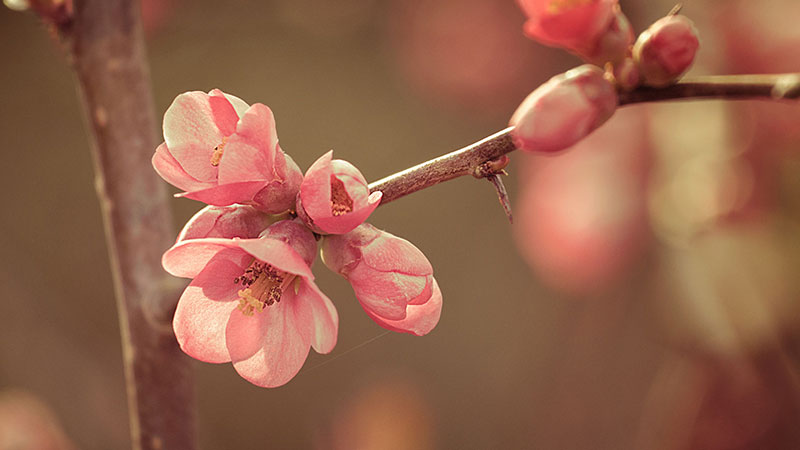

In [212]:
im = Image.open('images/1.jpg')
im

In [213]:
buf_in = allocate((im.height,im.width,3,), np.uint32, cacheable=True )
out_buffer = allocate(shape=(im.height,im.width,3,), dtype=np.uint32,  cacheable=True )

In [214]:
buf_in[:] = np.array(im)

In [215]:
encDecTime = {"pl_encoding":[], "pl_decoding":[], "ps_encoding":[], "ps_decoding":[], "pl_encoding_multi":0, "ps_encoding_multi": 0}

In [216]:
dma0 = overlay.axi_dma_0
px=overlay.pixel

## Word to decimal


In [217]:
def convertWordToDecimal(wordString):
    wordInDecimal = 0
    
    for character in wordString:
        wordInDecimal = wordInDecimal*100 + ord(character)
        
    return wordInDecimal

In [218]:
def get_hidden_characters(decimal_values):
    
    dec_string = ""
    num = int(decimal_values)
    for x in range(len(str(num))):
        #dec_string += str(int(num)%100)
        print(chr(int(num)%100),end='')
        num = num // 100

## Embedding

In [219]:
wordInDecimal = convertWordToDecimal("HITT")

In [220]:
position1 = 1
position2 = 32
stream_count= position2 - position1 +1 

In [221]:
# Embedding characters in the image - Register Map
px.register_map.in_decimal_i=wordInDecimal ## concatinating three ascii character values 50  65  89
px.register_map.position1=position1         ## starting
px.register_map.position2=position2        ## ending 
px.register_map.selector = 0        ## encoding mode
px.register_map.stream_count= stream_count#im.width * im.height * 3  ##size of stream

#### change buffers to 1D array

In [222]:
in_buffer_1d=buf_in.ravel()
out_buffer_1d=out_buffer.ravel()


#### Embedding characters in the image - DMA

In [223]:
#running 10 times for the same image to find the average time
encDecTime["pl_encoding"] = []
for i in range (10):
    start_time = time.time()
    dma0.sendchannel.transfer(in_buffer_1d[position1-1:position2])
    dma0.recvchannel.transfer(out_buffer_1d[position1-1:position2])
    dma0.sendchannel.wait()
    dma0.recvchannel.wait()
    end_time = time.time()
    encDecTime["pl_encoding"].append(end_time - start_time)

In [224]:
# add untouched values( the rest ) to the out_buffer_1d
out_buffer_1d[position2:] = in_buffer_1d[position2:]

In [225]:
# getting 3d out buffer from 1d out buffer
out_buffer_3d = np.copy(out_buffer_1d).reshape(im.height,im.width,3)

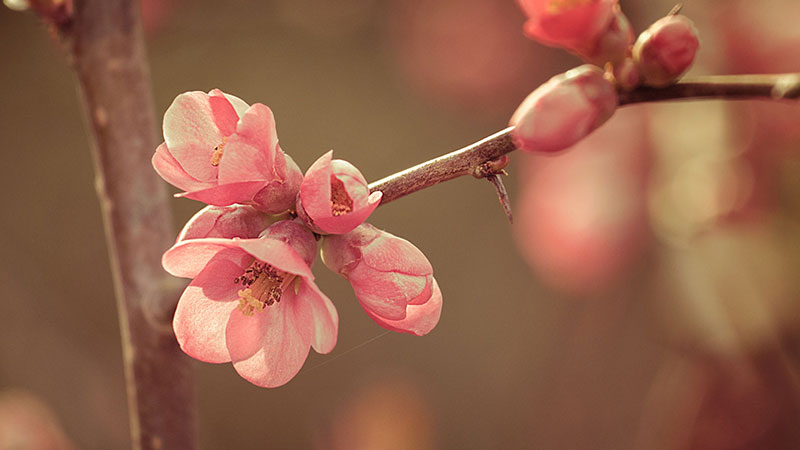

In [226]:
#Displaying encoded image from out_buffer_3d
encodedImage = Image.fromarray((out_buffer_3d).astype('uint8'))

display(encodedImage)

In [163]:
#Checking time
encDecTime["pl_encoding"]

[0.004472017288208008,
 0.0013885498046875,
 0.0013015270233154297,
 0.0020530223846435547,
 0.0014252662658691406,
 0.0014090538024902344,
 0.001306295394897461,
 0.00141143798828125,
 0.001421213150024414,
 0.0014247894287109375]

## Decoding

In [239]:
# Decrypting characters from the image - Register Map
px.register_map.position1=position1
px.register_map.position2=position2
px.register_map.selector = 1 #decode mode
px.register_map.stream_count= stream_count#im.width * im.height * 3


###### Decrypting characters from the image - DMA

In [240]:
encDecTime["pl_decoding"] = []
for i in range (10):
    start_time = time.time()
    dma0.sendchannel.transfer(out_buffer_1d[position1-1:position2])
    dma0.recvchannel.transfer(out_buffer_1d[position1-1:position2])
    dma0.sendchannel.wait()
    dma0.recvchannel.wait()
    end_time = time.time()
    encDecTime["pl_decoding"].append(end_time - start_time)

### Getting the decimal value fromthe encoded image and find the secret charchters

In [241]:
decimal_values = px.register_map.in_decimal_o
get_hidden_characters(decimal_values)

HITT    

### decoding time PL

In [242]:
encDecTime["pl_decoding"]

[0.004690885543823242,
 0.0013148784637451172,
 0.0017333030700683594,
 0.0012631416320800781,
 0.001882791519165039,
 0.0018277168273925781,
 0.001489400863647461,
 0.0015697479248046875,
 0.0021924972534179688,
 0.0012574195861816406]

## PS

In [230]:
#Function to convert decimal to binary
def convert(n):
    binn = 0
    rem = 0
    i=1
    step = 1
    while (n != 0):
        rem = n % 2
        n //= 2
        binn += rem * i
        i *= 10
    return binn

In [231]:
#Function to get the the binary value of the given decimal
def decrypt(data):
    global final_char
    bit=0
#     final_char=0
    if(data % 2 == 0):
        bit = 0
    elif(data % 2 != 0):
        bit=1
        
    final_char= final_char*10+bit

In [232]:
# Functions to get decimal value from a binary number
def convertBinInt(n):
    
    dec=0
    rem=0
    b = 0
    i = 7
    
    while (n != 0):
        b=pow(10,i)
        rem = n // b
        n =n % b
        dec += rem * pow(2, 7-i)
        i -= 1
        
    return dec


def getDecimal(n):
    num = 0
    num = n % 100
    return num

### Pixel function

In [233]:
final_char=0
decimalOut = 0

def pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps_1d, imh, imw):
    decimalCounter = 0
    global decimalOut
    global final_char
    charDecimalString = ''
    
    
    for i in range(stream_count):
        
        if not selector:
            
            if (i == 0):
                final_char=0
                decNum = in_decimal
            
            if((i >= (position1 - 1)) and (i < position2)):
                    addNum=0
                    if(decimalCounter % 8 == 0):
                        lastDecimalVal = getDecimal(decNum)
                        decNum = decNum // 100
                        charIn=convert(lastDecimalVal)
                        
                    addNum=charIn%10
                    charIn=charIn//10

                    if(buf_in_ps_1d[i] % 2 == 0 and addNum == 1):
                        buf_in_ps_1d[i] += 1
                    
                    elif(buf_in_ps_1d[i] % 2 != 0 and addNum == 0):
                        buf_in_ps_1d[i] -= 1
                    
                    decimalCounter=decimalCounter+1

                    
        elif selector:
            
            if((i >= (position1 - 1)) and (i < position2)):
                
                decrypt(buf_in_ps_1d[i])
                decimalCounter=decimalCounter+1
                
                if(decimalCounter == 8):
                                        
                    charDecimalString += str(convertBinInt(final_char))
                    decimalCounter=0
                    final_char=0


            if (i == stream_count-1):
                decimalOut = int(charDecimalString)
                
    out_buffer_ps_3d = np.copy(buf_in_ps_1d).reshape(imh,imw,3)

    return out_buffer_ps_3d

## Encrypting using PS


In [234]:
in_decimal=wordInDecimal

selector=0
position1 = 1
position2 = 32
stream_count= position2 - position1 +1 

buf_in_ps_1d = in_buffer_1d

In [235]:
encDecTime["ps_encoding"] =[]
for i in range(10):
    start_time = time.time()
    out_buffer_ps_3d = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps_1d,im.height,im.width)
    end_time = time.time()
    encDecTime["ps_encoding"].append(end_time - start_time)

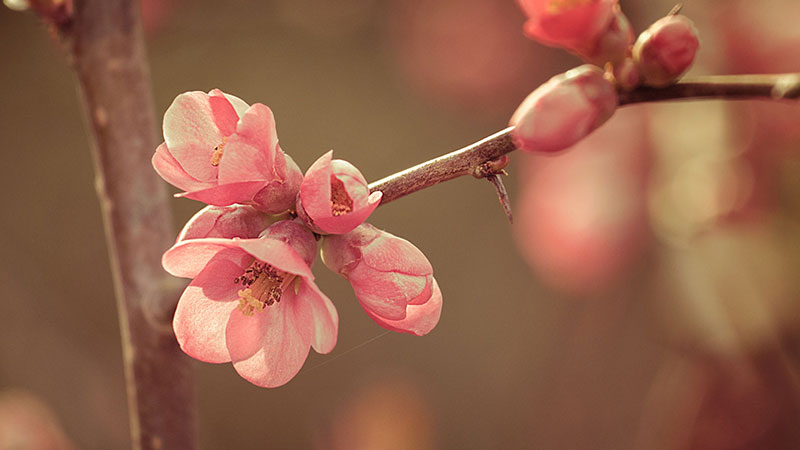

In [236]:
im_out_ps = Image.fromarray((out_buffer_ps_3d).astype('uint8'))

display(im_out_ps)

In [189]:
encDecTime["ps_encoding"]


[0.03322005271911621,
 0.030114173889160156,
 0.02798938751220703,
 0.0281832218170166,
 0.027747631072998047,
 0.027883052825927734,
 0.027505874633789062,
 0.027486085891723633,
 0.02751612663269043,
 0.02753281593322754]

## Decoding using PS


In [243]:

selector=1
position1 = 1
position2 = 32
stream_count= position2 - position1 +1 
buf_in_ps_decode=out_buffer_3d.ravel() ##turn 3d array to 1d array

In [244]:
encDecTime["ps_decoding"] = []
for i in range(10):
    start_time = time.time()
    out_buffer_ps_3d = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps_decode,im.height, im.width)
    end_time = time.time()
    encDecTime["ps_decoding"].append(end_time - start_time)


In [245]:
get_hidden_characters(decimalOut)

HITT    

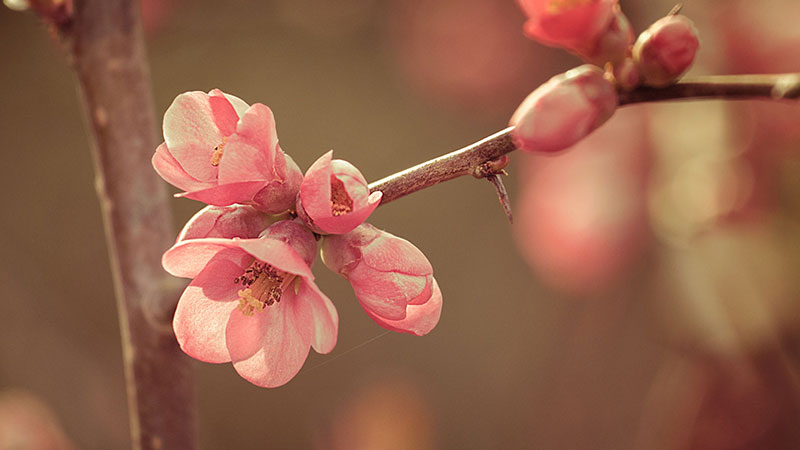

In [199]:
im_out_ps = Image.fromarray((out_buffer_ps_3d).astype('uint8'))

display(im_out_ps)

In [200]:
encDecTime["ps_decoding"]

[0.03950214385986328,
 0.028573274612426758,
 0.028451919555664062,
 0.028608083724975586,
 0.02895641326904297,
 0.028533935546875,
 0.02874588966369629,
 0.02882695198059082,
 0.028586626052856445,
 0.028464317321777344]

# TIME COMPARISON

## Encoding PS-PL Comparison

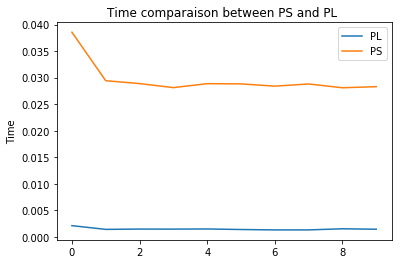

In [238]:
x1 = [i for i in range(10)]
y1 = encDecTime["pl_encoding"]

# plotting the line 1 points 
plt.plot(x1, y1, label = "PL")
# line 2 points
x2 = [i for i in range(10)]
y2 = encDecTime["ps_encoding"]
# plotting the line 2 points 
plt.plot(x2, y2, label = "PS")
# plt.xlabel('Images')
# Set the y axis label of the current axis.
plt.ylabel('Time')
# Set a title of the current axes.
plt.title('Time comparaison between PS and PL ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

## Decoding PS-PL Comparison

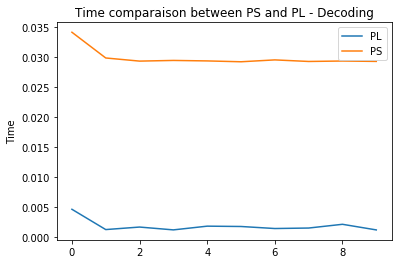

In [246]:
x1 = [i for i in range(10)]
y1 = encDecTime["pl_decoding"]

# plotting the line 1 points 
plt.plot(x1, y1, label = "PL")
# line 2 points
x2 = [i for i in range(10)]
y2 = encDecTime["ps_decoding"]
# plotting the line 2 points 
plt.plot(x2, y2, label = "PS")
# plt.xlabel('Images')
# Set the y axis label of the current axis.
plt.ylabel('Time')
# Set a title of the current axes.
plt.title('Time comparaison between PS and PL - Decoding')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

## Encoding multiple different images

In [254]:
def encode_multiple(image_paths):
    encDecTime["pl_encoding_multi"] = 0
    
    for image in image_paths:
        
        imageToEncode = Image.open(image)
        buf_in = allocate((imageToEncode.height, imageToEncode.width,3,), np.uint32, cacheable=True )
        out_buffer = allocate(shape=(imageToEncode.height, imageToEncode.width,3,), dtype=np.uint32,  cacheable=True )
        buf_in[:] = np.array(imageToEncode)
        in_buffer_1d=buf_in.ravel()
        out_buffer_1d=out_buffer.ravel()

        start_time = time.time()
        dma0.sendchannel.transfer(in_buffer_1d[position1-1:position2])
        dma0.recvchannel.transfer(out_buffer_1d[position1-1:position2])
        dma0.sendchannel.wait()
        dma0.recvchannel.wait()
        end_time = time.time()
        # add untouched values( the rest ) to the out_buffer_1d
        out_buffer_1d[position2:] = in_buffer_1d[position2:]
        listOfOutBuffers.append(out_buffer_1d)
        
        
        encDecTime["pl_encoding_multi"] += end_time - start_time


In [255]:
listOfOutBuffers = []
image_paths = !ls images/*.jpg

wordInDecimal = convertWordToDecimal("HITT")
position1 = 1
position2 = 32
stream_count= position2 - position1 +1 

# Embedding characters in the image - Register Map
px.register_map.in_decimal_i=wordInDecimal ## concatinating three ascii character values 50  65  89
px.register_map.position1=position1         ## starting
px.register_map.position2=position2        ## ending 
px.register_map.selector = 0        ## encoding mode
px.register_map.stream_count= stream_count#im.width * im.height * 3  ##size of stream

encode_multiple(image_paths)
encDecTime["pl_encoding_multi"]

0.030735492706298828

## Decoding multiple different images

In [265]:
def decode_multiple():
    encDecTime["pl_decoding_multi"] = 0
    
    for buf_1d in listOfOutBuffers:

        start_time = time.time()
        dma0.sendchannel.transfer(buf_1d[position1-1:position2])
        dma0.recvchannel.transfer(buf_1d[position1-1:position2])
        dma0.sendchannel.wait()
        dma0.recvchannel.wait()
        end_time = time.time()
        decimal_values = px.register_map.in_decimal_o
        
        encDecTime["pl_decoding_multi"] += end_time - start_time


In [266]:
px.register_map.selector = 1
px.register_map.position1=1
px.register_map.position2=32

stream_count= position2 - position1 +1 
decode_multiple()

encDecTime["pl_decoding_multi"]

HITT    HITT    HITT    HITT    HITT    HITT    HITT    HITT    HITT    HITT    

0.016962528228759766

## Encoding multiple different images - PS

In [291]:
def encode_multiple_ps(image_paths):
    
    for image in image_paths:
        
        imageToEncode = Image.open(image)
        
        buf_in = allocate((imageToEncode.height, imageToEncode.width,3,), np.uint32, cacheable=True )
        out_buffer = allocate(shape=(imageToEncode.height, imageToEncode.width,3,), dtype=np.uint32,  cacheable=True )
        buf_in[:] = np.array(imageToEncode)
        buf_in_ps=buf_in.ravel()
        
        start_time = time.time()
        out_buffer_ps = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps,imageToEncode.height,imageToEncode.width )
        end_time = time.time()
        
        listOfOutBuffersPS.append(out_buffer_ps)
        
        encDecTime["ps_encoding_multi"] += end_time - start_time

In [292]:
listOfOutBuffersPS = []
image_paths = !ls images/*.jpg

selector=0
position1 = 1
position2 = 32
stream_count= position2 - position1 +1
in_decimal=convertWordToDecimal("HITT")

encDecTime["ps_encoding_multi"] = 0
encode_multiple_ps(image_paths)

In [293]:
encDecTime["ps_encoding_multi"]

0.27297520637512207

## Decoding multiple different images - PS

In [294]:
def decode_multiple_ps():
    
    for buf in listOfOutBuffersPS:
        height = len(buf)
        width = len(buf[0])
        
        buf_1d = buf.ravel()
        
        start_time = time.time()
        out_buffer_ps = pixel(in_decimal, selector, position1, position2, stream_count, buf_1d, height, width)
        end_time = time.time()
        
        encDecTime["ps_decoding_multi"] += end_time - start_time

In [295]:
selector=1
position1 = 1
position2 = 32
stream_count= position2 - position1 +1
encDecTime["ps_decoding_multi"] = 0

decode_multiple_ps()

## Showing time comparison - Encoding

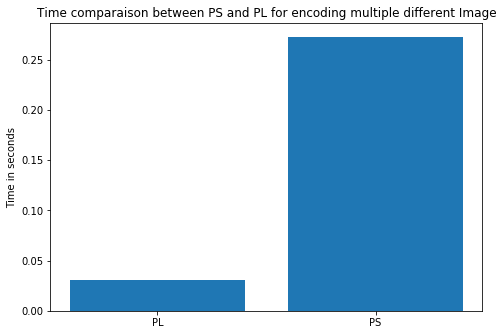

In [297]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
method = ['PS', 'PL']
timing = [encDecTime["ps_encoding_multi"], encDecTime["pl_encoding_multi"]]
ax.bar(method,timing)
plt.title('Time comparaison between PS and PL for encoding multiple different Image')
plt.ylabel('Time in seconds')

plt.show()

## Showing time comparison - Decoding

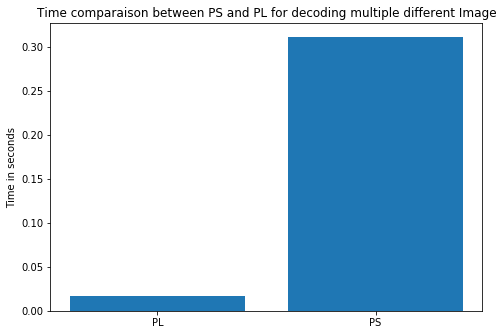

In [298]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
method = ['PS', 'PL']
timing = [encDecTime["ps_decoding_multi"], encDecTime["pl_decoding_multi"]]
ax.bar(method,timing)
plt.title('Time comparaison between PS and PL for decoding multiple different Image')
plt.ylabel('Time in seconds')

plt.show()

In [92]:
encDecTime

{'pl_decoding': [0.003319263458251953],
 'pl_encoding': [0.0032358169555664062],
 'pl_encoding_multi': [0.1933119297027588,
  0.19462990760803223,
  0.19455432891845703,
  0.1945328712463379,
  0.19449162483215332,
  0.19446015357971191,
  0.19438529014587402,
  0.1945967674255371,
  0.19448137283325195,
  0.19458913803100586],
 'ps_decoding': [0.009368181228637695],
 'ps_encoding': [0.011892080307006836],
 'ps_encoding_multi': [2.373753309249878,
  2.3757882118225098,
  2.414264440536499,
  2.3709146976470947,
  2.418814182281494,
  2.4141645431518555,
  2.482292890548706,
  2.3726041316986084,
  2.3729894161224365,
  2.3755910396575928]}

In [42]:

for i,key in enumerate(encDecTime.keys()):
    encDecTime[key].append(i+6)

In [43]:
x=encDecTime['pl_encoding']
y=encDecTime['pl_decoding']
z=encDecTime['pl_encoding_multi']

xc=encDecTime['ps_encoding']
yc=encDecTime['ps_decoding']
zc=encDecTime['ps_encoding_multi']


In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [45]:
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)
xs,ys,zs =x,y,z
ax.scatter(xs,ys,zs,marker='o',label='fpga')
xs,ys,zs =xc,yc,zc
ax.scatter(xs,ys,zs,marker='*',label='cpu')
plt.xlabel('pixels in')
plt.ylabel('pixels out')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [84]:
wordInDecimal = convertWordToDecimal("ANY")

## multiple images

In [86]:
image_paths = !ls images/*.jpg
encDecTime["pl_encoding_multi"]
encode_multiple(image_paths)

In [87]:
encDecTime["pl_encoding_multi"]

[0.1933119297027588,
 0.19462990760803223,
 0.19455432891845703,
 0.1945328712463379,
 0.19449162483215332,
 0.19446015357971191,
 0.19438529014587402,
 0.1945967674255371,
 0.19448137283325195,
 0.19458913803100586]

In [88]:
in_decimal=wordInDecimal

In [89]:
def encode_multiple_ps(image_paths):
    
    for image in image_paths:
        
        imageToEncode = Image.open(image)
        
        buf_in = allocate((imageToEncode.height, imageToEncode.width,3,), np.uint32, cacheable=True )
        out_buffer = allocate(shape=(imageToEncode.height, imageToEncode.width,3,), dtype=np.uint32,  cacheable=True )
        buf_in[:] = np.array(imageToEncode)
        buf_in_ps=buf_in.ravel()
        
        selector=1
        position1=1000000
        position2=1000023
        stream_count=imageToEncode.height * imageToEncode.width * 3
        
        start_time = time.time()
        out_buffer_ps = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps,imageToEncode.height,imageToEncode.width )
        end_time = time.time()
        
        encDecTime["ps_encoding_multi"].append(end_time - start_time)


In [90]:
encDecTime["ps_encoding_multi"]
encode_multiple_ps(image_paths)

In [94]:
for i in encDecTime["ps_encoding_multi"]:
    sum=sum+i

encDecTime["ps_encoding_multi"]=[].append(sum/len(encDecTime["ps_encoding_multi"]))

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'float'